<a href="https://colab.research.google.com/github/timpara/qf_lecture/blob/main/01_lecture_pairs_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hedging

To idea behind pairs trading relies on hedging. In particular, you are using short sales to hedge long investments. A short sale makes money if the security sold loses value, while a long purchase makes money if a security gains value. By longing parts of the market and shorting others, if the entire market falls, you can still make money on the shorted securities and hopefully break even. When you are long on one security and short on another, it is called a hedged position.

## Pairs trading

The trick of pairs trading comes from maintaining a hedged position across two securities, X and Y. As the securities drift towards and apart from each other, there will be times when the distance is high and times when it is low. You make money on the spread of the two reverting to the mean. To do this:

- Watch for when X and Y are far apart, then short Y and long X
- Watch for when they're close together, and long Y and short X

### Going long vs going short the Spread

When the spread is small and you expect it to become larger, place a bet by longing Y and shorting X. When the spread is large and you expect it to become smaller, place a bet by shorting Y and longing X. The important concept is that you are placing a bet on one specific thing and trying to reduce your bet's dependency on other factors such as the market.

## Identify potential assets for pairs trading

The most effective approach is to begin with securities that you believe may be cointegrated based on your economic hypothesis, and then conduct a statistical test to confirm your suspicion. Performing statistical tests on all possible pairs of securities will result in multiple comparison bias, which can lead to false positives.


The methods for finding viable pairs live on the following spectrum:

1. Formation of an economic hypothesis for an individual pair, leading you to test for cointegration. This incurs no multiple comparisons bias.

2. Performing a search through hundreds of securities for any viable pairs. This incurs a very large amount of multiple comparisons bias.

Multiple comparisons bias is the increased chance to incorrectly generate a significant p-value when many tests are run. If 100 tests are run on random data, we should expect to see 5 p-values below 0.05 on expectation (increased risk for false positive findings).

In practice, a second verification step would be needed if looking for pairs this way. Another approach is to pick a small number of pairs you have reason to suspect might be cointegrated and test each individually.

In [ ]:
#%sh
!pip install simfin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 995.6 kB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import simfin as sf
sf.set_data_dir()
from simfin.names import *
from google.colab import userdata


## Identifying Cointegrated Pairs based on empirical data

In [ ]:
sf.set_api_key(userdata.get('SIMFIN_API_KEY'))
df_prices = sf.load_shareprices(market='us', variant='daily')

Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... 

/usr/local/lib/python3.10/dist-packages/simfin/load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,


Done!


In [ ]:
unique_tickers = df_prices.index.get_level_values('Ticker').unique()
print(unique_tickers)

Index(['A', 'AA', 'AAC', 'AACI', 'AAGH', 'AAIC', 'AAL', 'AAMC', 'AAME', 'AAN',
       ...
       'ZTS', 'ZUMZ', 'ZUO', 'ZUUS', 'ZVIA', 'ZVO', 'ZVSA', 'ZY', 'ZYNE',
       'ZYXI'],
      dtype='object', name='Ticker', length=5194)


In [ ]:
years = [2020, 2021, 2022]
df_2022 = df_prices.loc[df_prices.index.get_level_values('Date').year.isin(years)]
# Group by ticker and sum the volume
volume_by_ticker = df_2022.groupby('Ticker')['Volume'].sum()

# Sort the tickers by volume in descending order and select the top n
top_n_tickers = volume_by_ticker.nlargest(30)

print(top_n_tickers)

Ticker
HCMC    789277243256
PHIL    162746351324
TSLA     99654479411
TGGI     89507363175
SANP     87068816650
AAPL     84714786185
SEEK     83538057275
SPY      67605615500
AMZN     61057145926
NIO      59912565975
F        57444453872
AHFD     56049756712
AMD      51431623480
BAC      41063385144
T        40643617479
QQQ      39897187339
AAL      35792557876
NVDA     34845580107
AITX     34437090574
CCL      32888099166
ZOM      30093020209
ADTM     29611945741
PLTR     28720313905
NOK      26143354890
INTC     25026466257
MSFT     23903564183
SNAP     23851540889
GME      23743599968
WFC      23444579318
GOOG     23097013318
Name: Volume, dtype: int64


In [ ]:
from statsmodels.tsa.stattools import coint
def find_cointegrated_pairs(data,tickers):
    """

    """
    n = len(tickers)
    keys = data.columns
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    pairs = []

    for i,ticker_A in enumerate(tickers):
        series_A = data.loc[ticker_A,"Close"]
        for j,ticker_B in enumerate(tickers):
            series_B = data.loc[ticker_B,"Close"]
            if ticker_A == ticker_B:
                continue
            if len(series_A) != len(series_B):
                continue

            score, pvalue,_ =  coint(series_A, series_B)
            if score == 0.0:
                continue
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((ticker_A, ticker_B,score,pvalue))

    return score_matrix, pvalue_matrix, pairs

In [ ]:
scores, pvalues, pairs = find_cointegrated_pairs(df_2022,top_n_tickers.index)

In [ ]:
pairs

[('AAPL', 'F', -3.507891520923797, 0.03170220538157909),
 ('AAPL', 'WFC', -3.4391979538469006, 0.03817955390176344),
 ('SPY', 'F', -3.354129886872744, 0.04770678381265601),
 ('SPY', 'BAC', -3.4436305509705782, 0.037730375731405356),
 ('SPY', 'MSFT', -3.355834232655914, 0.0474981975601455),
 ('SPY', 'GME', -3.3840710318866463, 0.04415075022160663),
 ('SPY', 'WFC', -3.347244926798417, 0.0485571137026427),
 ('SPY', 'GOOG', -3.360854182669393, 0.04688820554499398),
 ('F', 'AAPL', -3.379776058188913, 0.044646909027025415),
 ('F', 'SPY', -3.3566035880323657, 0.04740428718648262),
 ('F', 'BAC', -3.559642207968609, 0.027461954728232558),
 ('F', 'NVDA', -3.641000865670736, 0.021780043943181983),
 ('F', 'MSFT', -3.6327581816283647, 0.022305101570172205),
 ('F', 'WFC', -3.3844330530054436, 0.044109139445315235),
 ('BAC', 'SPY', -3.336292038394684, 0.04993558460599778),
 ('BAC', 'F', -3.587469602346997, 0.025389819717552928),
 ('BAC', 'MSFT', -3.444640417946855, 0.03762866423297404),
 ('BAC', 'GME

The coint function tests for no cointegration between two time series. The null hypothesis is that there is no cointegrating relationship. It returns 3 main values:

    coint_t: The t-statistic from the cointegrating regression. This will be a negative number.
    pvalue: The p-value associated with the t-statistic. This is based on the asymptotic distribution of the test statistic.
    crit_value: A dictionary with the critical values for the test statistic at the 1%, 5%, and 10% levels. These critical values are also negative.

Interpreting the results:

    If the pvalue is small, typically below 0.05, then you can reject the null hypothesis of no cointegration. This means the two series are likely cointegrated.
    The more negative the t-statistic (coint_t), and the smaller the p-value, the stronger the evidence for cointegration.
    You can compare the t-statistic to the critical values. If coint_t is more negative than the critical values, that also suggests rejecting the null of no cointegration.

So in summary:

    A more negative t-statistic and smaller p-value indicates stronger evidence of a cointegrating relationship
    Typically you want to see a p-value less than 0.05 to conclude the series are cointegrated
    The critical values provide thresholds for the t-statistic at different significance levels

A lower p-value is better in terms of concluding that the series are cointegrated. The p-value is the key metric to look at from these results in making inferences about cointegration.


## Calculating the Spread
To calculate the spread between two cointegrated securities, we use a linear regression to estimate the coefficient for the linear combination, a method known as the Engle-Granger approach. This technique is introduced in the Integration, Cointegration, and Stationarity lecture. Traditionally, examining the price ratio of a trading pair is a common way to handle pairs trading. This approach is based on the assumption that stock prices are log-normally distributed, implying that taking a ratio of the prices is equivalent to taking a linear combination of their associated returns (since prices are exponentiated returns). However, purchasing the precise ratio of a trading pair may not be practical. Instead, we choose to calculate the spread between the cointegrated stocks using linear regression. While this is a simple approach, it may not be feasible for non-toy examples. There are other potential methods for estimating the spread, which are listed at the bottom of this lecture. For a deeper understanding of why cointegrated stocks matter for pairs trading, please refer to the Integration, Cointegration, and Stationarity Lecture. In our example, the absolute spread is not very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score.
## Theory vs Practice
Normalizing the spread is usually done to provide some scale to the data, but this assumes an underlying distribution, typically a normal distribution. Financial data is not normally distributed, skewed, non-stationary and one must be cautious not to assume normality or any specific distribution when generating statistics. If the true distribution of spreads is very fat-tailed and prone to extreme values, it could disrupt our model and result in large losses.

In [ ]:
def get_spread(series_A,series_B):
    return series_A-series_B


In [ ]:
def get_z_score(series_A):
    z_score = (series_A-series_A.mean())/np.std(series_A)
    return z_score

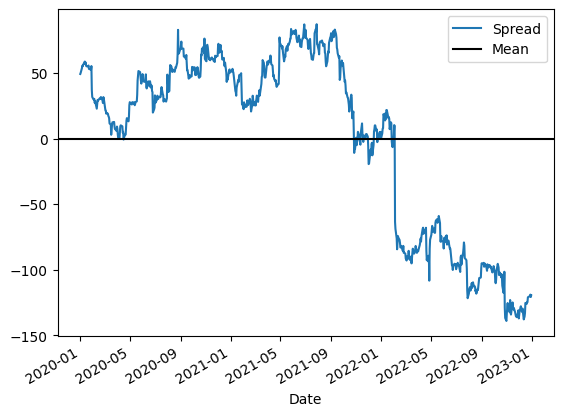

In [ ]:
from matplotlib import pyplot as plt
series_A = df_2022.loc['META','Close']
series_B = df_2022.loc['MSFT','Close']

spread = get_spread(series_A,series_B)
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread', 'Mean']);

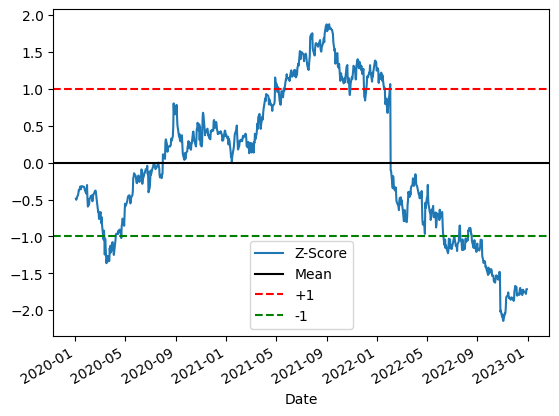

In [ ]:
z_score = get_z_score(series_A)
z_score.plot()
plt.axhline(z_score.mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Z-Score', 'Mean', '+1', '-1']);


When trading, relying on statistics calculated over the entire sample size can be problematic. For instance, if the market and both securities are trending upward, the average price over the past three years may not accurately represent the current market conditions. To address this issue, traders often employ statistics based on rolling windows of the most recent data.

## (Rolling) Moving Averages
A moving average is simply the average of the last $n$ datapoints at each given time. It will be undefined for the initial $n$ datapoints in the series. Shorter moving averages are more responsive to new information but can be more volatile and less reliable. Conversely, longer moving averages provide smoother results but require more time to incorporate new information.

## Rolling Beta
In addition to moving averages, we will also introduce the concept of a rolling beta. This will be a continuously updated estimate of how the spread should be calculated. By employing a rolling beta, all the parameters used in the trading strategy are kept up to date, ensuring that the most relevant information is considered.

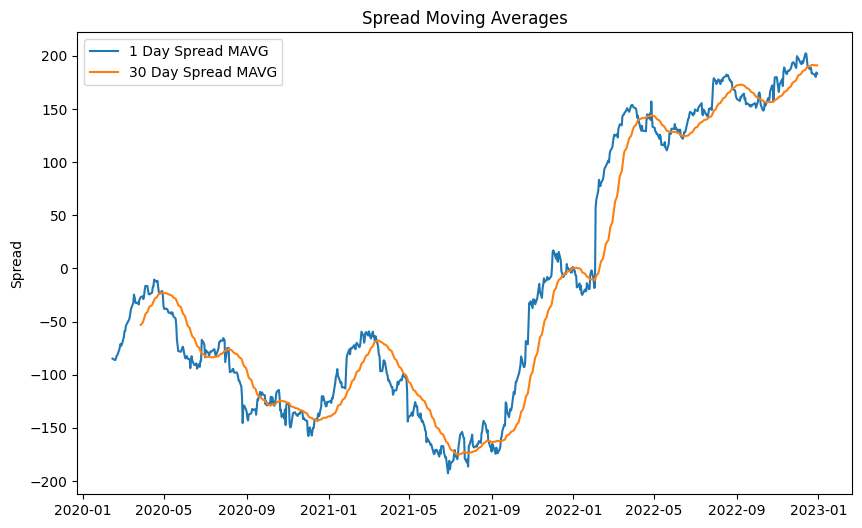

In [ ]:
import statsmodels.api as sm
import pandas as pd
def calculate_spread_and_plot(series_A, series_B, window):
    """
    Calculate the spread between two stocks using a rolling beta coefficient and plot the moving averages.

    Parameters:
    - series_A (pd.Series): Price series of stock A.
    - series_B (pd.Series): Price series of stock B.
    - window (int): Window size for calculating the rolling beta coefficient (default=30).

    Returns:
    - spread (pd.Series): Spread between the two stocks.
    - spread_mavg1 (pd.Series): 1-day moving average of the spread.
    - spread_mavg30 (pd.Series): 30-day moving average of the spread.
    """
    # Calculate rolling beta coefficient
    rolling_beta = [np.nan] * window
    for n in range(window, len(series_A)):
        y = series_A[(n - window):n]
        X = series_B[(n - window):n]
        rolling_beta.append(sm.OLS(y, X).fit().params.iloc[0])

    rolling_beta = pd.Series(rolling_beta, index=series_B.index)

    # Get the spread between the 2 stocks
    spread = series_B - rolling_beta * series_A
    spread.name = 'spread'

    # Get the 1 day moving average of the price spread
    spread_mavg1 = spread.rolling(window=1).mean()
    spread_mavg1.name = 'spread 1d mavg'

    # Get the 30 day moving average
    spread_mavg30 = spread.rolling(30).mean()
    spread_mavg30.name = 'spread 30d mavg'

    # Plot the moving averages
    plt.figure(figsize=(10, 6))
    plt.plot(spread_mavg1.index, spread_mavg1.values)
    plt.plot(spread_mavg30.index, spread_mavg30.values)
    plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])
    plt.ylabel('Spread')
    plt.title('Spread Moving Averages')
    plt.show()

    return spread, spread_mavg1, spread_mavg30
lookback_window=30
spread, spread_mavg1, spread_mavg30 = calculate_spread_and_plot(series_A, series_B,lookback_window)

We can utilize the same concept of rolling moving average to compute the z score.

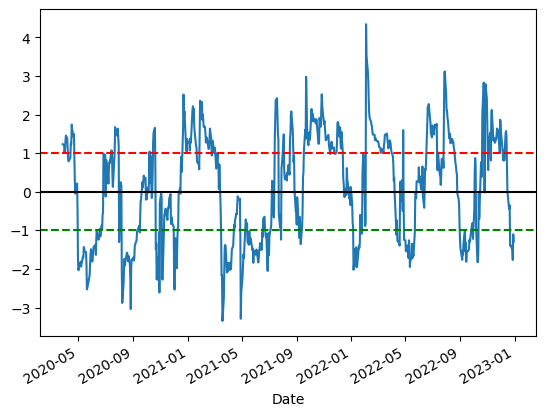

In [ ]:
# Compute rolling std
std_30 = spread.rolling(lookback_window).std()
std_30.name = f'Std {lookback_window}d'

# Compute the daily z score
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');
plt.axhline(-1.0, color='green', linestyle='--');

(array([18262., 18383., 18506., 18628., 18748., 18871., 18993., 19113.,
        19236., 19358.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01')])

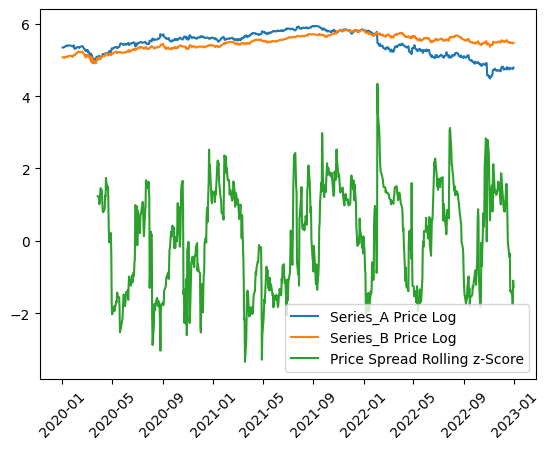

In [ ]:
# Plot the data all together.
plt.plot(series_A.index, np.log(series_A.values))
plt.plot(series_B.index, np.log(series_B.values))
plt.plot(zscore_30_1.index, zscore_30_1.values)
plt.legend(['Series_A Price Log', 'Series_B Price Log', 'Price Spread Rolling z-Score']);
plt.xticks(rotation=45)

Simple Pair Trading Strategy

    Enter a "Long" position in the spread when the spread falls below -X
    Enter a "Short" position in the spread when the spread rises above X
    Close out positions as the spread approaches zero

Note that this example provides only a basic illustration of the pair trading concepts. In a real-world scenario, you would need to calculate a more optimal weighting to determine the appropriate number of shares to hold for each stock in the pair (S1 and S2). Additional resources on pair trading strategies are provided at the end of this notebook for further reading.

## Out of sample testing
Now that we identified the cointegrated series, before running any backtest, we can just check if the conintegration still exists in 2023.

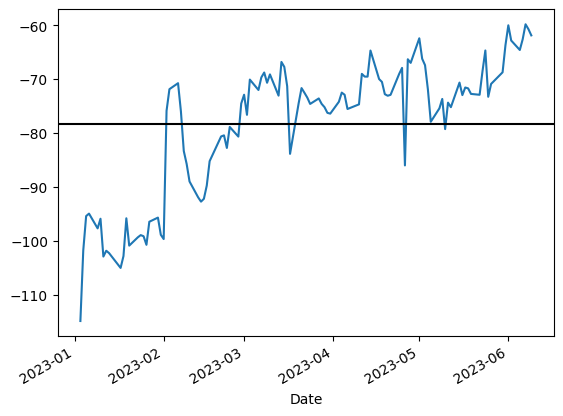

In [ ]:
df_2023 = df_prices.loc[df_prices.index.get_level_values('Date').year == 2023]
series_A = df_2023.loc['META','Close']
series_B = df_2023.loc['MSFT','Close']

spread = get_spread(series_A,series_B)
spread.plot()
plt.axhline(spread.mean(), color='black')




In [ ]:
score, pvalue,_ =  coint(series_A, series_B)


## Going Forward

In practice, when implementing a pairs trading strategy, it is advisable to trade multiple pairs simultaneously. Even if you identify a strong pair relationship through data analysis, there is no assurance that this relationship will persist in the future. By trading a diverse set of pairs, you create a diversified portfolio that helps mitigate the risk associated with individual pairs losing their cointegration properties. This approach ensures that your overall strategy is not overly reliant on the performance of a single pair and provides a more robust and resilient trading system.